<a href="https://colab.research.google.com/github/rcurrie/pancan-gtex/blob/master/infer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys
import os
import json
import requests
import numpy as np
import pandas as pd
!pip install -q tables
import tensorflow as tf
from IPython.core.display import display, HTML

# Create and switch to a scratch data directory so all paths are local
os.makedirs(os.path.expanduser("~/data/pancan-gtex"), exist_ok=True)
os.chdir(os.path.expanduser("~/data/pancan-gtex"))

In [2]:
# Setup S3 connection to download the training set and trained model
import boto3
from botocore.handlers import disable_signing

bucket_name = "stuartlab"
endpoint = "s3.nautilus.optiputer.net"

# Set so that Tensorflow can pull from the PRP S3/CEPH storage cluster
os.environ["S3_ENDPOINT"] = endpoint

session = boto3.session.Session()
resource = boto3.resource("s3", endpoint_url="https://{}".format(endpoint))
resource.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
bucket = resource.Bucket(bucket_name)

# Output the data and checksums for the dataset and trained model
print("Dataset and Model:")
for obj in bucket.objects.filter(Prefix="pancan-gtex"):
    print(obj.last_modified.isoformat(), obj.e_tag[1:-1], obj.key) 

Dataset and Model:
2018-11-23T17:26:45.350000+00:00 ef1c9c15b5a1fd836521f0759e57dfa7-120 pancan-gtex
2019-01-25T04:23:03.187000+00:00 20a89dbc58cfb88efaad1567b8f62cff pancan-gtex/ensemble-to-hugo.tsv
2019-01-25T04:22:59.779000+00:00 2507895ba8b46cb1458b40764b81ee14-47 pancan-gtex/pancan-gtex-pruned.h5
2019-01-25T04:25:29.799000+00:00 10d6cce19b63beb8809d4eca687df355 pancan-gtex/pruned-model.h5
2019-01-25T04:25:28.344000+00:00 7850096c28a10a7740180045581bdce0 pancan-gtex/pruned-params.json


In [3]:
if not os.path.exists("pancan-gtex-pruned.h5"):
    print("Downloading dataset...")
    bucket.download_file("pancan-gtex/pancan-gtex-pruned.h5", "pancan-gtex-pruned.h5")
    
print("Loading dataset...")
X = pd.read_hdf("pancan-gtex-pruned.h5", "samples")
Y = pd.read_hdf("pancan-gtex-pruned.h5", "labels")
print("Loaded {} samples with {} features and {} labels".format(X.shape[0], X.shape[1], Y.shape[1]))
    
if not os.path.exists("ensemble-to-hugo.tsv"):
    r = requests.get("https://s3.nautilus.optiputer.net/stuartlab/pancan-gtex/ensemble-to-hugo.tsv")
    open("ensemble-to-hugo.tsv", "wb").write(r.content)
    
ensemble_to_hugo = pd.read_table("ensemble-to-hugo.tsv", index_col=0)

Loading dataset...
Loaded 17277 samples with 5540 features and 40 labels


In [4]:
# Load params and trained model from S3
r = requests.get("https://s3.nautilus.optiputer.net/stuartlab/pancan-gtex/pruned-params.json")
params = r.json()

r = requests.get("https://s3.nautilus.optiputer.net/stuartlab/pancan-gtex/pruned-model.h5")

import tempfile
temp_path = "/tmp/{}.h5".format(next(tempfile._get_candidate_names()))
open(temp_path, "wb").write(r.content)

model = tf.keras.models.load_model(temp_path)
os.remove(temp_path)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5540)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 5540)              22160     
_________________________________________________________________
dense (Dense)                (None, 64)                354624    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 34)                2210      
Total para

In [30]:
from google.colab import files

!rm abundance.tsv

uploaded = files.upload()

Saving abundance.tsv to abundance.tsv


In [31]:
# Load the sample's expression kallisto TPM output
filename = list(uploaded.keys())[0]

# # Process local sample
# filename = os.path.expanduser("~/data/samples/TH06_1172_S01/abundance.tsv")

sample = pd.read_table(filename, index_col=0, engine='c').astype(np.float32).T.loc[["tpm"]]
assert int(sample.iloc[0].sum()) == 1000000
sample.head()

target_id,ENST00000619216.1,ENST00000473358.1,ENST00000469289.1,ENST00000607096.1,ENST00000417324.1,ENST00000461467.1,ENST00000335137.3,ENST00000466430.5,ENST00000495576.1,ENST00000477740.5,...,ENST00000306641.1,ENST00000612245.1,ENST00000361963.3,ENST00000306609.4,ENST00000516617.1,ENST00000417334.1,ENST00000516816.1,ENST00000515987.1,ENST00000517139.1,ENST00000620883.1
tpm,26.0229,0.0,0.0,0.0,0.0,0.0,0.0,2.07142,0.0,0.0,...,1.19823,0.507383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
ensemble_to_hugo = pd.read_table(
    "https://s3.nautilus.optiputer.net/stuartlab/pancan-gtex/ensemble-to-hugo.tsv", index_col=0)
print("Found {} transcript to hugo mappings".format(ensemble_to_hugo.shape[0]))
print(ensemble_to_hugo.shape)
ensemble_to_hugo.head()

Found 216139 transcript to hugo mappings
(216139, 1)


,gene
transcript,
ENST00000545363.6,RP11-705C15.2
ENST00000480456.5,JAM2
ENST00000633293.1,CPEB1
ENST00000564050.6,PRMT7
ENST00000622921.1,LINC01128


In [33]:
# Convert from Kallisto ensembl TPM to hugo concordant with the compendium and prune
    
missing = len(list(filter(lambda x: x not in ensemble_to_hugo.index, sample.columns.values)))
print("{} transcripts have no hugo mapping".format(missing))

# Create a new dataframe replacing the index
hugo = sample.copy()
# hugo.columns = ensemble_to_hugo.reindex(transcripts)["gene"].values

hugo.columns = ensemble_to_hugo.reindex(sample.columns).gene.values


# Multiple Ensemble genes map to the same Hugo name. Each of these values has been normalized via log2(TPM+0.001)
# so we convert back into TPM to sum.
hugo_reduced = hugo.groupby(axis="columns", level=0).aggregate(np.sum).sort_index(axis="columns")
print("After collapsing genes we have {} features".format(hugo_reduced.shape[1]))

# Check that we still sum to roughly 1M net of dropped transcripts due to no mapping
print("sum(tpm):", hugo_reduced.sum(axis="columns").values[0])

# Prune to match training set
sample_features = hugo_reduced.drop(labels=(set(hugo_reduced.columns) - set(X.columns.values)), axis=1)
print("Pruned features down to {} genes".format(sample_features.shape[1]))

# Make sure we have the same features in the same order as our training set
assert X.columns.equals(sample_features.columns)

0 transcripts have no hugo mapping
After collapsing genes we have 44792 features
sum(tpm): 1000000.1
Pruned features down to 5540 genes


## Classification

In [49]:
# predict processes multiple samples and returns a list of predictions
# We just have one so take the first
prediction = model.predict(sample_features)[0]

tumor_normal_prediction_index = int(round(prediction[0]))
tumor_normal_prediction_value = prediction[0] if prediction[0] >= 0.5 else (1 - prediction[0])
tumor_normal_prediction_label = params["tumor_normal"][tumor_normal_prediction_index]
display(HTML("<h3>{} ({:.2f})</h3>".format(
    tumor_normal_prediction_label, tumor_normal_prediction_value)))

primary_site_prediction_index = np.argmax(prediction[1:-1])
primary_site_prediction_value = prediction[1:-1][primary_site_prediction_index]
primary_site_prediction_label = params["primary_site"][primary_site_prediction_index]
display(HTML("<h3>{} ({:.2f})</h3>".format(
    primary_site_prediction_label, primary_site_prediction_value)))

## Pan disease explanation

In [35]:
!pip install -q shap==0.28.3
import shap
shap.initjs()

# Select a set of background samples of the same disease to take an expectation over
Y_background = Y[(Y._primary_site == primary_site_prediction_label) 
                 & (Y.tumor_normal == tumor_normal_prediction_label)]
X_background = X.loc[Y_background.index]
print("Found {} {} {} training samples".format(
    X_background.shape[0], primary_site_prediction_label, tumor_normal_prediction_label))

Found 515 Adipose Tissue Normal training samples


In [36]:
%%time
np.random.seed(42)
background = X_background.iloc[np.random.choice(X_background.shape[0], 200, replace=False)]
print("Randomly selecting {} out of {} {} samples as background to compute an expectatin over".format(
    background.shape[0], X_background.shape[0], primary_site_prediction_label))
explainer = shap.DeepExplainer(model, background)

Randomly selecting 200 out of 515 Adipose Tissue samples as background to compute an expectatin over
CPU times: user 56 ms, sys: 10 ms, total: 66 ms
Wall time: 82.5 ms


In [37]:
%%time
# Explain predictions of model for our focus sample
sample_shap_values = explainer.shap_values(sample_features.iloc[0:1].values)

CPU times: user 16.8 s, sys: 155 ms, total: 17 s
Wall time: 15.8 s


### Genes driving all possible focus sample classifications

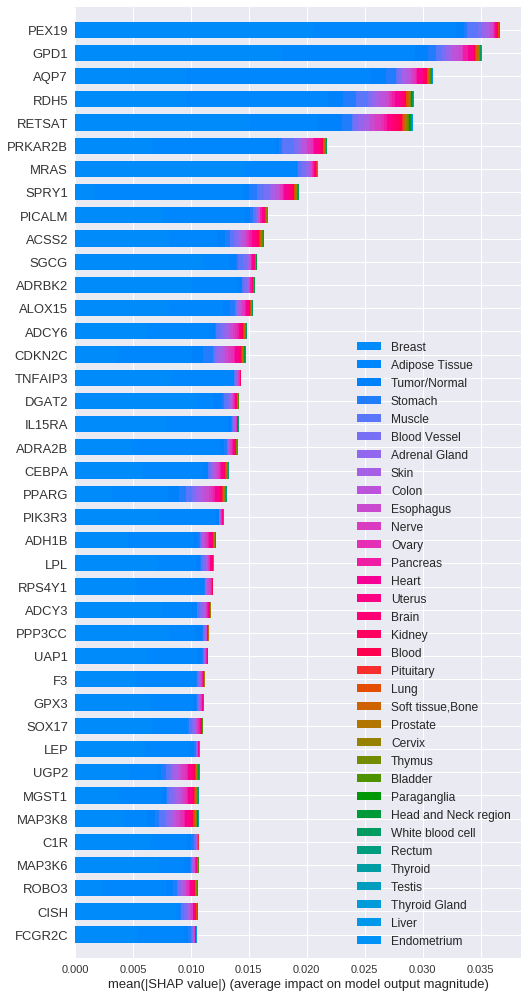

In [38]:
shap.summary_plot(sample_shap_values, background, max_display=40, 
                  class_names=["Tumor/Normal"] + params["primary_site"])

### Genes driving tumor/normal focus sample classification

In [39]:
shap.force_plot(explainer.expected_value[0], sample_shap_values[0], sample_features, link="identity")

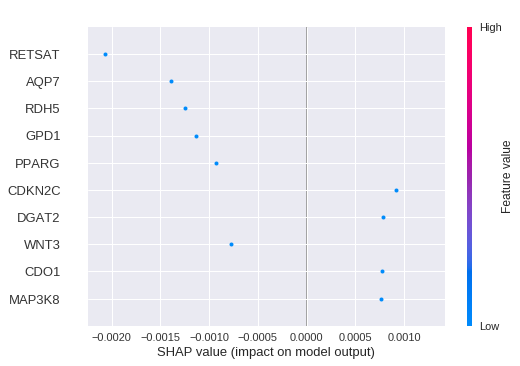

In [40]:
shap.summary_plot(shap_values=sample_shap_values[0], 
                  features=sample_features.iloc[0:1].values, feature_names=X.columns.values,
                  max_display=10, class_names=["Tumor/Normal"] + params["primary_site"])

### Genes driving primary site focus sample classification

In [41]:
shap.force_plot(explainer.expected_value[primary_site_prediction_index + 1],
                sample_shap_values[primary_site_prediction_index + 1], 
                sample_features, link="identity")

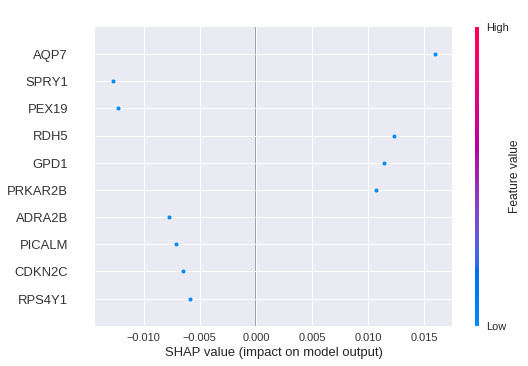

In [42]:
shap.summary_plot(shap_values=sample_shap_values[primary_site_prediction_index + 1], 
                  features=sample_features.iloc[0:1].values, feature_names=X.columns.values,
                  max_display=10, class_names=["Tumor/Normal"] + params["primary_site"])

### Enrished pathway identifation from SHAP values
(not complete)
https://bmcgenomics.biomedcentral.com/articles/10.1186/1471-2164-11-574

In [43]:
max_display = 10
# feature_order = np.argsort(np.sum(np.mean(np.abs(sample_shap_values), axis=0), axis=0))
feature_order = np.argsort(abs(sample_shap_values[primary_site_prediction_index + 1][0]))
feature_order = feature_order[-min(max_display, len(feature_order)):]
print("Top gene's driving primary site prediction")
print([X.columns.values[i] for i in feature_order])

Top gene's driving primary site prediction
['RPS4Y1', 'CDKN2C', 'PICALM', 'ADRA2B', 'PRKAR2B', 'GPD1', 'RDH5', 'PEX19', 'SPRY1', 'AQP7']


### Genes driving tumor/normal classification for all background samples

In [44]:
%%time
# Explain predictions of model for all background samples
background_shap_values = explainer.shap_values(background.values)

CPU times: user 9min 38s, sys: 9.59 s, total: 9min 48s
Wall time: 5min 44s


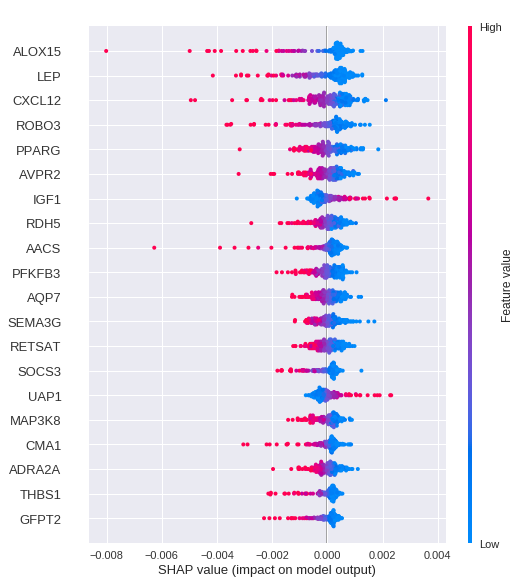

In [45]:
shap.summary_plot(background_shap_values[0], background, plot_type='dot')

### Genes driving primary site classification for all background samples

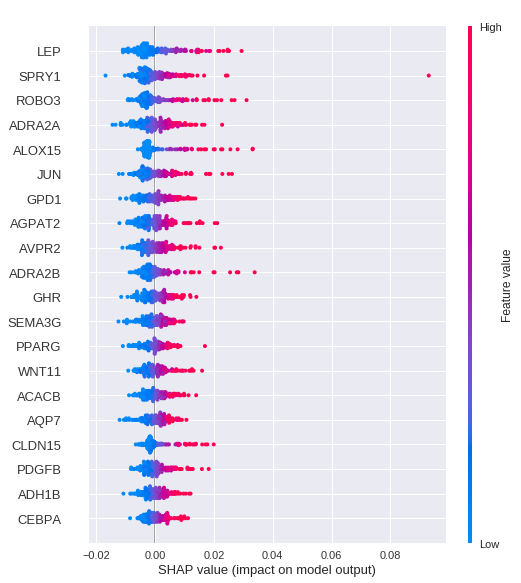

In [46]:
shap.summary_plot(background_shap_values[primary_site_prediction_index + 1], background, plot_type='dot')

## Most Similar Samples
List closest by spearman distance samples from PanCan along with their relevant prognostic endpoints (OSS etc...)

In [47]:
import scipy
import sklearn.metrics.pairwise as sklp

def nearest_samples(cohort, sample, N=-1):
    """
    Compute the Spearman distance between sample and every member of the
    cohort and return the N nearest samples from the cohort.

    cohort, sample: Pandas data frames with columns=features/genes
    N: the number of most similar samples to return
    """
    # Column wise rank transform to turn correlation into spearman
    cohort_transformed = np.apply_along_axis(scipy.stats.rankdata, 1, cohort.values)
    sample_transformed = np.apply_along_axis(scipy.stats.rankdata, 1, sample.values)
    print(cohort_transformed.shape)
    print(sample_transformed.shape)

    # Compute spearman distances
    distances = sklp.pairwise_distances(X=cohort_transformed, Y=sample_transformed, metric="correlation", n_jobs=1)
            
    # Rank and return top N
    rank = 1 - pd.DataFrame(distances, cohort.index.values)
    return rank.sort_values(by=0, ascending=False)[0:N]

nearest = nearest_samples(background, sample_features, 5)
nearest.head()

(200, 5540)
(1, 5540)


,0
GTEX-P78B-0226-SM-3NB1Z,0.967964
GTEX-ZPU1-1226-SM-5HL71,0.966986
GTEX-ZP4G-2326-SM-57WEM,0.966814
GTEX-YJ8O-2426-SM-5HL7S,0.966313
GTEX-WY7C-2426-SM-3NB2V,0.965755
